<a href="https://colab.research.google.com/github/toraaglobal/SREIT/blob/master/04_explore_and_modeling_prophet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:

## Import packages
from fbprophet import Prophet
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sqlite3
import pickle
import datetime as dt
from sklearn.metrics import mean_squared_error


%matplotlib inline

In [2]:
## OBTAIN


#Mount the gdrive
import os
from google.colab import drive
drive.mount('/content/drive')


#change directry to the gdrive

os.chdir('./drive/My Drive/Colab Notebooks/code')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
def read_csv(path):
  '''read data from path and return train and test set for prophet'''
  df = pd.read_csv(path)
  df = df.rename(index=str, columns={'RegionName': "Zipcode"})
  df['Date'] = pd.to_datetime(df['Date'])
  ## Data type convertion
  df['Zipcode'] = df['Zipcode'].astype(str)
  df['RegionID'] = df['RegionID'].astype(str)
  
  ## Training set : 1997 - 2017
  df_train = df[(df.Date.dt.year > 1996) & (df.Date.dt.year <= 2017) ]
  df_test = df[df.Date.dt.year == 2018]
  
  
  ## rename column for prophet model
  df_train = df_train.rename(index=str, columns={'Date':'ds', 'Values':'y'})
  df_test = df_test.rename(index=str, columns={'Date':'ds', 'Values':'y'})
  return df_train, df_test



train, test = read_csv('single_family_prep.csv')

print(train.info())
print(test.info())
  
  
  
  
  

<class 'pandas.core.frame.DataFrame'>
Index: 3901212 entries, 139329 to 4040540
Data columns (total 10 columns):
Unnamed: 0    int64
RegionID      object
Zipcode       object
City          object
State         object
Metro         object
CountyName    object
SizeRank      int64
ds            datetime64[ns]
y             float64
dtypes: datetime64[ns](1), float64(1), int64(2), object(6)
memory usage: 327.4+ MB
None
<class 'pandas.core.frame.DataFrame'>
Index: 185772 entries, 4040541 to 4226312
Data columns (total 10 columns):
Unnamed: 0    185772 non-null int64
RegionID      185772 non-null object
Zipcode       185772 non-null object
City          185772 non-null object
State         185772 non-null object
Metro         169488 non-null object
CountyName    185772 non-null object
SizeRank      185772 non-null int64
ds            185772 non-null datetime64[ns]
y             185772 non-null float64
dtypes: datetime64[ns](1), float64(1), int64(2), object(6)
memory usage: 15.6+ MB
None


In [4]:
## print train data
train.head()

Unnamed: 0 RegionID Zipcode     City State  \
139329      139329    60657   60657  Chicago    IL   
139330      139330    77494   77494     Katy    TX   
139331      139331    60614   60614  Chicago    IL   
139332      139332    77449   77449     Katy    TX   
139333      139333    79936   79936  El Paso    TX   

                                   Metro      CountyName  SizeRank         ds  \
139329          Chicago-Naperville-Elgin     Cook County         1 1997-01-01   
139330  Houston-The Woodlands-Sugar Land   Harris County         2 1997-01-01   
139331          Chicago-Naperville-Elgin     Cook County         3 1997-01-01   
139332  Houston-The Woodlands-Sugar Land   Harris County         4 1997-01-01   
139333                           El Paso  El Paso County         5 1997-01-01   

               y  
139329  344900.0  
139330  197300.0  
139331  503200.0  
139332   96600.0  
139333   77800.0

/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


(array([3.724302e+06, 6.173000e+03, 4.600000e+02, 1.790000e+02,
        1.020000e+02, 1.020000e+02, 5.100000e+01, 1.100000e+01,
        6.000000e+00, 3.000000e+01]),
 array([1.230000e+04, 1.944880e+06, 3.877460e+06, 5.810040e+06,
        7.742620e+06, 9.675200e+06, 1.160778e+07, 1.354036e+07,
        1.547294e+07, 1.740552e+07, 1.933810e+07]),
 <a list of 10 Patch objects>)

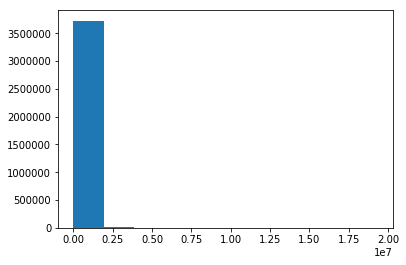

In [5]:
## Relationship between the sizerank and mean housing values

plt.hist(train.y)

/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


(array([3.781000e+03, 1.250600e+05, 1.100919e+06, 1.568507e+06,
        7.036730e+05, 1.958840e+05, 2.791600e+04, 4.975000e+03,
        4.760000e+02, 2.250000e+02]),
 array([ 9.41735454, 10.15337787, 10.88940119, 11.62542452, 12.36144785,
        13.09747117, 13.8334945 , 14.56951782, 15.30554115, 16.04156448,
        16.7775878 ]),
 <a list of 10 Patch objects>)

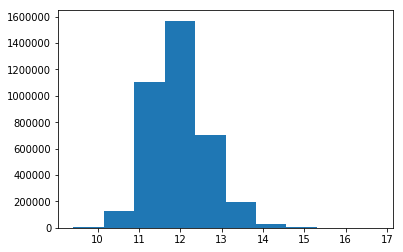

In [6]:
## log distribution

plt.hist(np.log(train.y))

In [7]:
train['log_values'] = np.log(train['y'].values)

train.head()

Unnamed: 0 RegionID Zipcode     City State  \
139329      139329    60657   60657  Chicago    IL   
139330      139330    77494   77494     Katy    TX   
139331      139331    60614   60614  Chicago    IL   
139332      139332    77449   77449     Katy    TX   
139333      139333    79936   79936  El Paso    TX   

                                   Metro      CountyName  SizeRank         ds  \
139329          Chicago-Naperville-Elgin     Cook County         1 1997-01-01   
139330  Houston-The Woodlands-Sugar Land   Harris County         2 1997-01-01   
139331          Chicago-Naperville-Elgin     Cook County         3 1997-01-01   
139332  Houston-The Woodlands-Sugar Land   Harris County         4 1997-01-01   
139333                           El Paso  El Paso County         5 1997-01-01   

               y  log_values  
139329  344900.0   12.751010  
139330  197300.0   12.192481  
139331  503200.0   13.128743  
139332   96600.0   11.478334  
139333   77800.0   11.261897

In [8]:
test['log_values'] = np.log(test['y'].values)
test.head()

Unnamed: 0 RegionID Zipcode     City State  \
4040541     4040541    60657   60657  Chicago    IL   
4040542     4040542    77494   77494     Katy    TX   
4040543     4040543    60614   60614  Chicago    IL   
4040544     4040544    77449   77449     Katy    TX   
4040545     4040545    79936   79936  El Paso    TX   

                                    Metro      CountyName  SizeRank  \
4040541          Chicago-Naperville-Elgin     Cook County         1   
4040542  Houston-The Woodlands-Sugar Land   Harris County         2   
4040543          Chicago-Naperville-Elgin     Cook County         3   
4040544  Houston-The Woodlands-Sugar Land   Harris County         4   
4040545                           El Paso  El Paso County         5   

                ds          y  log_values  
4040541 2018-01-01  1028300.0   13.843418  
4040542 2018-01-01   322600.0   12.684168  
4040543 2018-01-01  1309300.0   14.085003  
4040544 2018-01-01   173500.0   12.063933  
4040545 2018-01-01   120200.0   11.696912

In [9]:
## rename columns for prophet
train = train.rename(index=str, columns={'y': 'Values', 'log_values': 'y'})
test = test.rename(index=str, columns={'y': 'Values', 'log_values': 'y'})
train.head()


Unnamed: 0 RegionID Zipcode     City State  \
139329      139329    60657   60657  Chicago    IL   
139330      139330    77494   77494     Katy    TX   
139331      139331    60614   60614  Chicago    IL   
139332      139332    77449   77449     Katy    TX   
139333      139333    79936   79936  El Paso    TX   

                                   Metro      CountyName  SizeRank         ds  \
139329          Chicago-Naperville-Elgin     Cook County         1 1997-01-01   
139330  Houston-The Woodlands-Sugar Land   Harris County         2 1997-01-01   
139331          Chicago-Naperville-Elgin     Cook County         3 1997-01-01   
139332  Houston-The Woodlands-Sugar Land   Harris County         4 1997-01-01   
139333                           El Paso  El Paso County         5 1997-01-01   

          Values          y  
139329  344900.0  12.751010  
139330  197300.0  12.192481  
139331  503200.0  13.128743  
139332   96600.0  11.478334  
139333   77800.0  11.261897

In [10]:
test.head()

Unnamed: 0 RegionID Zipcode     City State  \
4040541     4040541    60657   60657  Chicago    IL   
4040542     4040542    77494   77494     Katy    TX   
4040543     4040543    60614   60614  Chicago    IL   
4040544     4040544    77449   77449     Katy    TX   
4040545     4040545    79936   79936  El Paso    TX   

                                    Metro      CountyName  SizeRank  \
4040541          Chicago-Naperville-Elgin     Cook County         1   
4040542  Houston-The Woodlands-Sugar Land   Harris County         2   
4040543          Chicago-Naperville-Elgin     Cook County         3   
4040544  Houston-The Woodlands-Sugar Land   Harris County         4   
4040545                           El Paso  El Paso County         5   

                ds     Values          y  
4040541 2018-01-01  1028300.0  13.843418  
4040542 2018-01-01   322600.0  12.684168  
4040543 2018-01-01  1309300.0  14.085003  
4040544 2018-01-01   173500.0  12.063933  
4040545 2018-01-01   120200.0  11.696912

In [0]:
train.to_csv('single_family_train.csv')
test.to_csv('single_family_test.csv')

In [0]:

## create a database connection
conn = sqlite3.connect('uszipmodel.sqlite')
cur = conn.cursor()

cur.execute('''
CREATE TABLE IF NOT EXISTS models_log (zip TEXT NOT NULL UNIQUE, model BLOB, mse REAL )''')
conn.commit()

In [0]:
def run_zip_model(df, zipcode, df_test):
  # initialize the model
  model = Prophet(interval_width=0.95)
  #check if Zipmodel already in database
  cur.execute("SELECT mse from models_log where zip = ?",(zipcode,))
  try:
    data = cur.fetchone()[0]
    #print("Model found in database")
  except:
    model.fit(df)
    
    #future_dates = df_test['ds']
    #print(future_dates.head())
    
    forecast = model.predict(df_test)
    #print(forecast.head())
    #actual
    y_actual = df_test['y']
    y_predict = forecast['yhat']
    #score
    score =  mean_squared_error(y_actual, y_predict)
    print(score)
    cur.execute('''INSERT INTO models_log (zip,model,mse)
    VALUES (?,?,?)''',(zipcode,pickle.dumps(model),score))
    
    conn.commit()

In [15]:
## get all zipcode in a list

zips = train['Zipcode'].unique()

zips = list(zips)

len(zips)

15481

In [18]:
count = 0
for zip in zips:
  train_df = train[train['Zipcode'] == zip]
  test_df = test[test['Zipcode']== zip]
  run_zip_model(train_df, zip, test_df)
  count+=1
  print("Counts: {}".format(count))
  conn.commit()

/usr/local/lib/python3.6/dist-packages/fbprophet/forecaster.py:880: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  min_dt = dt.iloc[dt.nonzero()[0]].min()
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


0.00014954668993690881
Counts: 1


/usr/local/lib/python3.6/dist-packages/fbprophet/forecaster.py:880: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  min_dt = dt.iloc[dt.nonzero()[0]].min()
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


0.001952285389801347
Counts: 2


/usr/local/lib/python3.6/dist-packages/fbprophet/forecaster.py:880: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  min_dt = dt.iloc[dt.nonzero()[0]].min()
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


0.00015376965056027535
Counts: 3


/usr/local/lib/python3.6/dist-packages/fbprophet/forecaster.py:880: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  min_dt = dt.iloc[dt.nonzero()[0]].min()
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


0.0032686970595985653
Counts: 4


/usr/local/lib/python3.6/dist-packages/fbprophet/forecaster.py:880: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  min_dt = dt.iloc[dt.nonzero()[0]].min()
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


0.0013006132934359727
Counts: 5


/usr/local/lib/python3.6/dist-packages/fbprophet/forecaster.py:880: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  min_dt = dt.iloc[dt.nonzero()[0]].min()
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


0.001799653191717929
Counts: 6


/usr/local/lib/python3.6/dist-packages/fbprophet/forecaster.py:880: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  min_dt = dt.iloc[dt.nonzero()[0]].min()
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


SystemError: ignored